In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Prepare input data
from sklearn.model_selection import train_test_split

Img = np.load('./V14_MC_vertical_imgs.npy')
E = np.load('./V14_MC_true_energy.npy')
Angle = np.load('./V14_MC_angle.npy')
Charge = np.load('./V14_MC_charge.npy')

X = Img
y = np.log10(E)
X0 = Angle

img_rows, img_cols = X[0].shape
input_shape = (img_rows, img_cols, 1)

X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = X.astype('float32')
X0 = np.reshape(Angle, (len(X0),1))

shuffler = np.random.permutation(len(X))
X_new = X[shuffler]
y_new = y[shuffler]
X0_new = X0[shuffler]

X_train, X_val, y_train, y_val = train_test_split(X_new[:-10000], y_new[:-10000], test_size=0.2, shuffle=False)
X0_train, X0_val = train_test_split(X0_new[:-10000], test_size=0.2, shuffle=False)
X_test = X_new[-10000:]
X0_test = X0_new[-10000:]
y_test = y_new[-10000:]

1

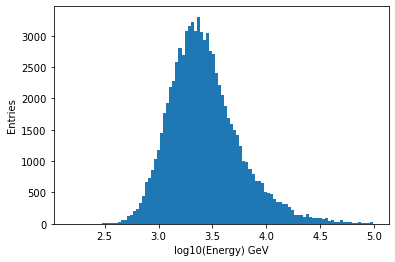

In [43]:
plt.hist(y, bins=100)
plt.xlabel('log10(Energy) GeV')
plt.ylabel('Entries')
1

In [4]:
#Define layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Concatenate
from tensorflow.keras.layers import concatenate

Input_imgs = Input(shape=input_shape)
Input_angle = Input(shape=(1))
Conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(Input_imgs)
Pool1 = MaxPooling2D(pool_size=(2, 2))(Conv1)
Conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(Pool1)
Pool2 = MaxPooling2D(pool_size=(2, 2))(Conv2)
Conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(Pool2)
Drop = Dropout(0.2)(Conv3)
Flat = Flatten()(Drop)
Concat = concatenate([Flat, Input_angle])

Hidden1 = Dense(128, activation='relu')(Concat)
Output = Dense(1, activation='linear')(Hidden1)

#Define the model
model = Model(inputs=[Input_imgs, Input_angle], outputs=Output)
model.compile(loss=tf.keras.losses.mse,
              optimizer=tf.keras.optimizers.Adam())

Epoch 1/10
1776/1776 [==============================] - 111s 62ms/step - loss: 0.3771 - val_loss: 0.1191
Epoch 2/10
1776/1776 [==============================] - 110s 62ms/step - loss: 0.1161 - val_loss: 0.1088
Epoch 3/10
1776/1776 [==============================] - 111s 63ms/step - loss: 0.1137 - val_loss: 0.1087
Epoch 4/10
1776/1776 [==============================] - 113s 64ms/step - loss: 0.1132 - val_loss: 0.1138
Epoch 5/10
1776/1776 [==============================] - 115s 65ms/step - loss: 0.1143 - val_loss: 0.1075
Epoch 6/10
1776/1776 [==============================] - 133s 75ms/step - loss: 0.1140 - val_loss: 0.1115
Epoch 7/10
1776/1776 [==============================] - 116s 65ms/step - loss: 0.1118 - val_loss: 0.1105
Epoch 8/10
1776/1776 [==============================] - 113s 64ms/step - loss: 0.1136 - val_loss: 0.1108
Epoch 9/10
1776/1776 [==============================] - 107s 60ms/step - loss: 0.1124 - val_loss: 0.1147
Epoch 10/10
1776/1776 [==============================] 

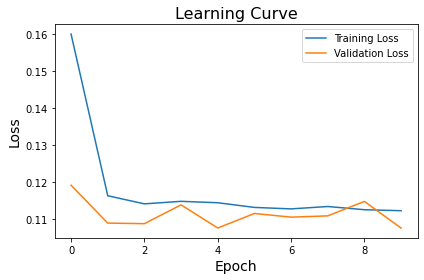

In [5]:
#Train
epochs = 10
history = model.fit([X_train, X0_train], y_train,
          batch_size=32,
          epochs=epochs,
          verbose=1,
          validation_data=([X_val, X0_val], y_val))

#Learning curve
mae=history.history['loss']
val_mae=history.history['val_loss']
epochs_range = range(epochs)
plt.plot(epochs_range, mae, label='Training Loss')
plt.plot(epochs_range, val_mae, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Learning Curve', fontsize=16)
plt.tight_layout()

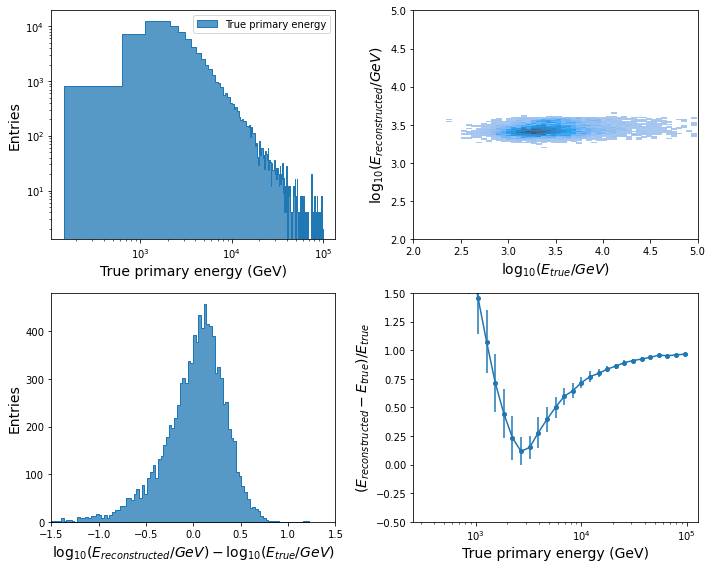

In [6]:
#Test set
prediction = model.predict([X_test, X0_test]) #Get predicted energy and restore true energy from log scale
test_predicted_energy = np.power(10, prediction)
test_true_energy = np.power(10, y_test)

test_predicted_energy = np.reshape(test_predicted_energy, (test_true_energy.shape))
loss = np.divide(abs(test_true_energy - test_predicted_energy), test_true_energy)

bins = np.logspace(2, 6, 50)
med_y = []
med_x = []
err = []
for i in range(len(bins)-1):
    idx = np.where((test_true_energy > bins[i])&(test_true_energy<bins[i+1]))[0]
    if len(idx)==0: continue
    med_y.append( np.median(loss[idx]) )
    med_x.append( (bins[i]+bins[i+1])/2 )
    err.append( abs((np.percentile(loss[idx], 84) - np.percentile(loss[idx], 16))/2) )

######
plt.figure(figsize=(10,8))

plt.subplot(221)
sns.histplot(E, bins=200, element='step', label='True primary energy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True primary energy (GeV)', fontsize=14)
plt.ylabel('Entries', fontsize=14)
plt.legend()
plt.tight_layout()

plt.subplot(222)
sns.histplot(x=np.log10(test_true_energy), y=np.log10(test_predicted_energy), bins=50)
plt.xlabel(r'$\log_{10}(E_{true}/GeV)$', fontsize=14)
plt.ylabel(r'$\log_{10}(E_{reconstructed}/GeV)$', fontsize=14)
plt.xlim(2,5)
plt.ylim(2,5)
plt.tight_layout()

plt.subplot(223)
sns.histplot((np.log10(test_predicted_energy) - np.log10(test_true_energy) ), bins=100, element='step')
plt.xlabel('$\log_{10}(E_{reconstructed}/GeV)-\log_{10}(E_{true}/GeV)$', fontsize=14)
plt.ylabel('Entries', fontsize=14)
plt.xlim(-1.5,1.5)
plt.tight_layout()

plt.subplot(224)
plt.errorbar(med_x[1:], med_y[1:], yerr=err[1:], marker='o',ms=4, ls='-')
plt.xscale('log')
plt.ylim(-0.5, 1.5)
plt.xlabel('True primary energy (GeV)', fontsize=14)
plt.ylabel('$(E_{reconstructed}-E_{true})/E_{true}$', fontsize=14)
plt.tight_layout()

#figname = './plots/' + 'all_elem_together' + '_loss' + '%0.3f'%np.median(loss) + '.jpg' 
#plt.savefig(figname)

In [37]:
diff = []
for k in range(100):
    for j in range(k+1,len(X)):
        diff.append(np.sum( np.abs(X[k]-X[j]) ) )
diff = np.array(diff)

In [29]:
diff

array([0.30822981, 0.32394135, 0.29986803, ..., 0.3516115 , 0.29611269,
       0.29160431])

1

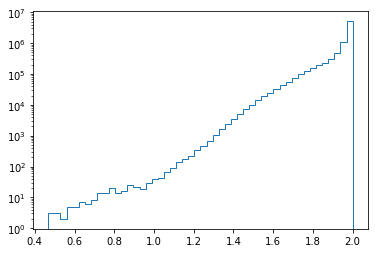

In [38]:
plt.hist(diff, bins=50, histtype='step')
plt.yscale('log')
1

In [36]:
np.sum(X[0])

1.0